# 🔍 Temporal-Difference Learning in GridWorld – A Step-by-Step Tutorial
In this notebook, we'll explore how to model a simple 2D environment (GridWorld) and solve it using Temporal-Difference (TD) Learning algorithms from Reinforcement Learning.

We'll cover:

- The environment layout (goals, traps, walls)

-  Defining rewards and interaction rules

- TD(0) Prediction – learning state values

- SARSA – On-policy control

- Q-Learning – Off-policy control

- Visualization of learned values and optimal policies

We’ll build this notebook step-by-step with a focus on clarity, visualization, and hands-on implementation.

line.png

## 🧱 Section 1: GridWorld Environment Setup

We define a simple 2D grid-based world where an agent (like a robot or Pac-Man) can move in four directions: **up, right, down, and left**.

Each cell in the grid can be one of the following:

- `0`: A normal cell. The agent can move into it and receives a small negative reward (e.g., -0.04) to encourage shorter paths.
- `1`: The goal. Reaching this cell ends the episode with a positive reward (e.g., +1).
- `2`: A poison cell. Entering this cell ends the episode with a penalty (e.g., -1).
- `3`: A wall. The agent cannot pass through this cell.

We define the environment using a grid map and create a class `GridWorld` to encapsulate the logic for:
- Computing state indices from grid positions
- Generating a reward function
- Visualizing the grid and policy arrows

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

class GridWorld:
    """
    GridWorld environment for TD Learning.
    Grid cell codes:
    0 = normal (step penalty)
    1 = goal (+1)
    2 = poison (-1)
    3 = wall (non-passable)
    """

    def __init__(self, grid_map, step_cost=-0.1, goal_reward=1.0, poison_penalty=-1.0):
        self.map = np.array(grid_map)
        self.num_rows, self.num_cols = self.map.shape
        self.num_states = self.num_rows * self.num_cols
        self.num_actions = 4  # up, right, down, left

        # Define rewards per cell type
        self.rewards = {
            0: step_cost,      # normal cell
            1: goal_reward,    # goal
            2: poison_penalty, # poison
            3: 0.0             # wall
        }

        self.reward_function = self._build_reward_function()

    def reset(self):
        """
        Resets the environment to the starting state.
        Returns:
            state (int): Initial non-terminal, non-wall state
        """
        while True:
            r = np.random.randint(self.num_rows)
            c = np.random.randint(self.num_cols)
            if self.map[r, c] == 0:  # Normal cell only
                self.current_state = self.get_state(r, c)
                break
        return self.current_state

    def step(self, action):
        """
        Takes an action from the current state and returns the result.
        Parameters:
            action (int): 0=up, 1=right, 2=down, 3=left
        Returns:
            next_state (int): resulting state
            reward (float): reward received
            done (bool): whether the episode has ended
        """
        r, c = self.get_position(self.current_state)

        # Define motion directions
        directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        dr, dc = directions[action]
        new_r, new_c = r + dr, c + dc

        # Check boundaries and walls
        if 0 <= new_r < self.num_rows and 0 <= new_c < self.num_cols and self.map[new_r, new_c] != 3:
            next_state = self.get_state(new_r, new_c)
        else:
            next_state = self.current_state  # Bounce back

        reward = self.reward_function[next_state]
        done = self.map[new_r, new_c] in [1, 2] if (0 <= new_r < self.num_rows and 0 <= new_c < self.num_cols) else False

        self.current_state = next_state
        return next_state, reward, done

    def _build_reward_function(self):
        rewards = np.zeros(self.num_states)
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state(r, c)
                cell_type = self.map[r, c]
                rewards[s] = self.rewards[cell_type]
        return rewards

    def get_state(self, row, col):
        return row * self.num_cols + col

    def get_position(self, state):
        return divmod(state, self.num_cols)

    def display_map(self):
        """
        Displays the GridWorld layout (walls, goal, poison, etc.)
        """
        fig, ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
        cmap = {0: 'white', 1: '#00917C', 2: '#FF5252', 3: 'black'}

        for r in range(self.num_rows):
            for c in range(self.num_cols):
                cell_type = self.map[r, c]
                rect = patches.Rectangle((c, self.num_rows - r - 1), 1, 1,
                                         facecolor=cmap[cell_type], edgecolor='gray')
                ax.add_patch(rect)

        ax.set_xlim(0, self.num_cols)
        ax.set_ylim(0, self.num_rows)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("GridWorld Layout")
        plt.show()

    def show_state_numbering(self):
        """
        Displays the grid with state numbers annotated in each cell.
        """
        fig, ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
        cmap = {0: 'white', 1: '#00917C', 2: '#FF5252', 3: 'black'}

        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state(r, c)
                cell_type = self.map[r, c]
                color = cmap[cell_type]

                rect = patches.Rectangle((c, self.num_rows - r - 1), 1, 1,
                                         facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

                if cell_type != 3:
                    ax.text(c + 0.5, self.num_rows - r - 0.5,
                            f"s = {s}", ha='center', va='center', fontsize=10, weight='bold')

        ax.set_xlim(0, self.num_cols)
        ax.set_ylim(0, self.num_rows)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title("GridWorld State Numbering", fontsize=14)
        plt.show()

    def display_reward_map(self):
        """
        Displays the grid with reward values annotated for each state.
        """
        fig, ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
        cmap = {0: 'white', 1: '#00917C', 2: '#FF5252', 3: 'black'}

        for r in range(self.num_rows):
            for c in range(self.num_cols):
                cell_type = self.map[r, c]
                s = self.get_state(r, c)
                color = cmap[cell_type]

                rect = patches.Rectangle((c, self.num_rows - r - 1), 1, 1,
                                         facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

                if cell_type != 3:
                    reward = self.reward_function[s]
                    ax.text(c + 0.5, self.num_rows - r - 0.5,
                            f"R = {reward:.2f}", ha='center', va='center', fontsize=10)

        ax.set_xlim(0, self.num_cols)
        ax.set_ylim(0, self.num_rows)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title("Reward Function Map")
        plt.show()


    def plot_state_values(self, values):
        """
        Plot state values as a heatmap.
        """
        reshaped = values.reshape(self.num_rows, self.num_cols)
        plt.figure(figsize=(self.num_cols+1.25, self.num_rows+1.25))
        ax = sns.heatmap(reshaped, annot=True, fmt=".2f", cmap="coolwarm",
                        annot_kws={"size": 14}, square=True, linewidths=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()

    def _quatromatrix(self, left, bottom, right, top, ax=None, triplotkw={}, tripcolorkw={}):
        if not ax:
            ax = plt.gca()
        n, m = left.shape

        a = np.array([[0, 0], [0, 1], [0.5, 0.5], [1, 0], [1, 1]])
        tr = np.array([[0, 1, 2], [0, 2, 3], [2, 3, 4], [1, 2, 4]])

        A = np.zeros((n * m * 5, 2))
        Tr = np.zeros((n * m * 4, 3), dtype=int)

        for i in range(n):
            for j in range(m):
                k = i * m + j
                A[k * 5:(k + 1) * 5, :] = np.c_[a[:, 0] + j, a[:, 1] + i]
                Tr[k * 4:(k + 1) * 4, :] = tr + k * 5

        C = np.c_[left.flatten(), bottom.flatten(), right.flatten(), top.flatten()].flatten()

        ax.triplot(A[:, 0], A[:, 1], Tr, **triplotkw)
        tripcolor = ax.tripcolor(A[:, 0], A[:, 1], Tr, facecolors=C, **tripcolorkw)
        return tripcolor

    def plot_action_values(self, q_values):
        """
        Visualizes Q-values (action-values) for each state in the grid.
        Triangles in each cell indicate value of Up (0), Right (1), Down (2), Left (3).
        """
        num_states, num_actions = q_values.shape
        assert num_states == self.num_states and num_actions == self.num_actions

        rows, cols = self.num_rows, self.num_cols
        top = q_values[:, 0].reshape((rows, cols))
        right = q_values[:, 1].reshape((rows, cols))
        bottom = q_values[:, 2].reshape((rows, cols))
        left = q_values[:, 3].reshape((rows, cols))

        # Text annotation positions
        top_pos = [(j + 0.38, i + 0.25) for i in range(rows) for j in range(cols)]
        right_pos = [(j + 0.65, i + 0.5) for i in range(rows) for j in range(cols)]
        bottom_pos = [(j + 0.38, i + 0.8) for i in range(rows) for j in range(cols)]
        left_pos = [(j + 0.05, i + 0.5) for i in range(rows) for j in range(cols)]

        fig, ax = plt.subplots(figsize=(cols*2.0, rows*2.0))
        ax.set_ylim(rows, 0)

        # Triangular heatmap with Q-values
        tripcolor = self._quatromatrix(left, bottom, right, top, ax=ax,
                                      triplotkw={"color": "k", "lw": 1},
                                      tripcolorkw={"cmap": "coolwarm"})

        # Add text annotations
        for i, (x, y) in enumerate(top_pos):
            ax.text(x, y, f"{top.flatten()[i]:.2f}", size=11, color="w")
        for i, (x, y) in enumerate(right_pos):
            ax.text(x, y, f"{right.flatten()[i]:.2f}", size=11, color="w")
        for i, (x, y) in enumerate(bottom_pos):
            ax.text(x, y, f"{bottom.flatten()[i]:.2f}", size=11, color="w")
        for i, (x, y) in enumerate(left_pos):
            ax.text(x, y, f"{left.flatten()[i]:.2f}", size=11, color="w")

        ax.margins(0)
        ax.set_aspect("equal")
        fig.colorbar(tripcolor)
        ax.set_title("Action-Value Function (Q-values)")
        plt.show()





### Creating the Grid-World

We’ll define a small 4×3 map for this experiment.

In [ ]:
# Define a 3x4 grid map layout:
# 0 = normal cell, 1 = goal, 2 = poison, 3 = wall

grid_map = [
    [0, 0, 0, 1],
    [0, 3, 0, 2],
    [0, 0, 0, 0]
]

# Initialize the GridWorld environment
env = GridWorld(grid_map)

---

### 🗺️ Visualizing the Grid World

Now that we’ve defined the environment, let’s visualize the grid layout. This helps us clearly see the positions of:

- ✅ Goal cells (green)
- ❌ Poison cells (red)
- ⬛ Wall cells (black)
- ⬜ Normal walkable cells (white)

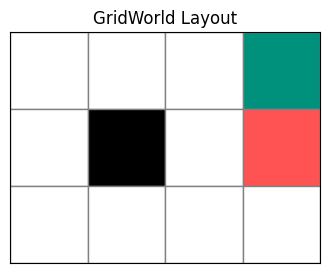

In [ ]:
# Show the grid with color-coded cells
env.display_map()

---


## 🔍 Inspecting the Grid World Internals

Now that we’ve visualized the layout of the environment, let’s take a deeper look into what’s happening behind each grid cell:

- **State Numbering**: States are numbered in row-major order.
- **Reward Function**: Each cell has an associated reward that the agent receives upon entering it.


This deeper inspection will help us understand how the agent perceives and interacts with the environment before we apply any learning algorithm.

---


### 🔢 2.1 State Numbering in GridWorld

Before we visualize rewards or value functions, it's helpful to understand how the GridWorld environment is numbered.

Each cell in the grid represents a unique **state**, and states are numbered in **row-major order** (left-to-right, top-to-bottom). The layout below shows the mapping from each `(row, col)` position to its corresponding state number.

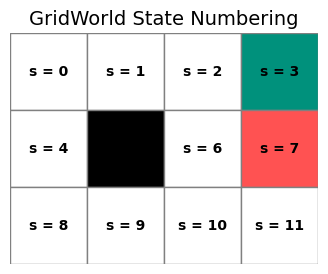

In [ ]:
# Call the function to display state numbering
env.show_state_numbering()

---

### 🎯 2.2 Rewards per State

Every cell in our GridWorld is associated with a numerical reward:

- `+1` for reaching the goal
- `–1` for stepping into a poison cell
- `–0.04` for each move through a normal cell (to encourage shorter paths)
- `0` for wall cells (which are impassable and don't change state)

Let’s plot these rewards directly onto the grid to make the incentive structure of the environment clear.


In [ ]:
# Call the function to display rewards
env.display_reward_map()

line.png

## 📘 Section 2: Temporal-Difference Learning (TD)

In this section, we move from modeling the environment to actually learning from interaction with it — without knowing the full model (i.e., no transition probabilities or reward dynamics upfront).

Temporal-Difference (TD) Learning is a core approach in reinforcement learning that combines:

- **Monte Carlo methods**, which learn from actual experience (i.e., sampled episodes), and  
- **Dynamic Programming**, which updates estimates based on other learned estimates (bootstrapping).

---

### **TD(0) Prediction**

#### ⏱️ What is TD(0) Prediction?

TD(0) is the simplest form of TD learning. Its goal is to **learn the value function** for a given **policy** based on **incomplete episodes** — by updating estimates **after every step** using the **TD error**.

The update rule is:

$$
V(s) \leftarrow V(s) + \alpha \left[ r + \gamma V(s') - V(s) \right]
$$

where:
- $ s $ is the current state  
- $ s' $ is the next state after taking an action  
- $ r $ is the reward received  
- $ \gamma $ is the discount factor  
- $ \alpha $ is the learning rate  

The term $ r + \gamma V(s') - V(s) $ is called the **TD error**. It measures the difference between the current estimate and a better estimate.

---




#### 🧠 TD(0) Prediction with Random Policy

We’ll now implement TD(0) learning using a **random policy**, i.e., the agent chooses a random action at each step. This allows us to observe how value estimates evolve just by interacting with the environment.

Let’s write the code step by step ⬇️

---

#### 🔁 TD(0) Prediction – Estimating State Values from Experience

The **TD(0)** algorithm estimates the value of each state under a given policy (here: a random policy).  
It updates value estimates after **every step** using the TD update rule:

$$
V(s) \leftarrow V(s) + \alpha \left( R + \gamma V(s') - V(s) \right)
$$


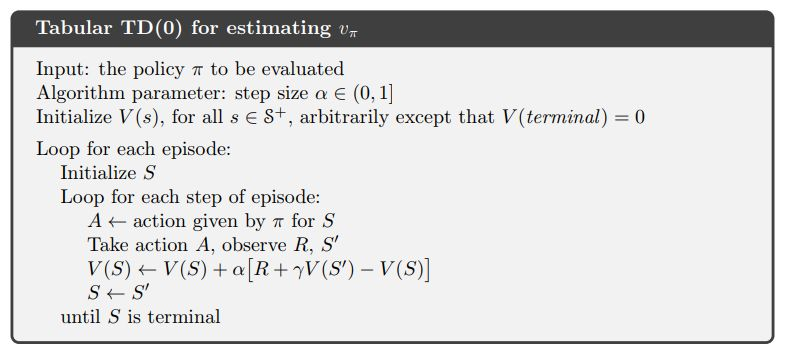

In [ ]:
def td_zero_prediction(env, num_episodes=5000, discount_factor=0.99, learning_rate=0.01):
    """
    Implements the TD(0) prediction algorithm to estimate state values.

    Parameters:
    - env: GridWorld environment object
    - num_episodes: number of episodes to run
    - discount_factor (gamma): how much future rewards are valued
    - learning_rate (alpha): step size for updating value estimates

    Returns:
    - V: A NumPy array of shape [num_states], with estimated state values
    """
    V = np.zeros(env.num_states)  # Initialize state-value function

    # Set terminal states (goal and poison) to their known final rewards
    for s in range(env.num_states):
        r, c = env.get_position(s)
        if env.map[r, c] in [1, 2]:  # Goal or poison
            V[s] = env.reward_function[s]

    for episode in range(num_episodes):
        state = env.reset()

        while True:
            # Choose a random action (uniform policy)
            action = np.random.randint(env.num_actions)

            # Take a step in the environment
            next_state, reward, done = env.step(action)

            # TD(0) Update
            V[state] += learning_rate * (
                reward + discount_factor * V[next_state] - V[state]
            )

            # Move to next state
            state = next_state

            if done:
                break

    return V

In [ ]:
# Run TD(0)
td_values = td_zero_prediction(env, num_episodes=5000, discount_factor=0.99, learning_rate=0.01)

# Visualize the learned value function
env.plot_state_values(td_values)

---
---

### 🔁 SARSA: On-Policy TD Control

SARSA (State–Action–Reward–State–Action) is an on-policy temporal-difference (TD) learning algorithm. It learns the action-value function $ Q(s, a) $ by updating based on the action taken **from the current policy**.

#### Key Concepts:
- It follows the current policy to generate episodes.
- Uses an epsilon-greedy policy for balancing exploration and exploitation.
- The update rule is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right]
$$

#### Advantages:
- It learns value estimates tied to the current behavior (on-policy).
- More stable than off-policy methods when the policy changes slowly.

---


#### 🧠 Algorithm

SARSA.png

---

#### 🧩 Implementation

In [ ]:
import numpy as np
import random

def sarsa(env, num_episodes=5000, alpha=0.01, gamma=0.99, epsilon_decay=0.99, min_epsilon=0.05):
    """
    SARSA algorithm: On-policy Temporal-Difference control to estimate the Q-function.
    """

    # Initialize Q-table with zeros: shape = [number of states x number of actions]
    Q = np.zeros((env.num_states, env.num_actions))

    # Optionally initialize Q-values for terminal states for stability
    for s in range(env.num_states):
        r, c = env.get_position(s)  # Get (row, col) of the state
        if env.map[r, c] == 1:      # Goal state
            Q[s, :] = 1.0
        elif env.map[r, c] == 2:    # Trap (death) state
            Q[s, :] = -1.0

    # Define epsilon-greedy action selection strategy
    def get_action(q_values, epsilon):
        if random.random() < epsilon:  # With probability ε, explore
            return random.randint(0, env.num_actions - 1)
        else:                          # Otherwise, exploit the best action
            return np.argmax(q_values)

    epsilon = 1.0  # Start with full exploration

    # Loop over episodes
    for episode in range(num_episodes):
        state = env.reset()  # Reset environment to a random starting state
        action = get_action(Q[state], epsilon)  # Choose initial action
        done = False  # Track episode termination

        while not done:
            next_state, reward, done = env.step(action)  # Take action → observe outcome
            next_action = get_action(Q[next_state], epsilon)  # Choose next action using policy

            # Compute the TD target and error
            td_target = reward + gamma * Q[next_state][next_action]
            td_error = td_target - Q[state][action]

            # Update the Q-value towards the TD target
            Q[state][action] += alpha * td_error

            # Move to the next state and action
            state = next_state
            action = next_action

        # Decay ε after each episode, but keep it above a minimum value
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    return Q  # Return the learned Q-table



In [ ]:
# Run SARSA
q_sarsa = sarsa(env, num_episodes=5000)

# Visualize the Q-values
env.plot_action_values(q_sarsa)


---
---

### 📘 **Q-Learning – Off-Policy TD Control**

**Q-Learning** is a foundational reinforcement learning algorithm that learns an optimal policy without requiring a model of the environment.  
It is an **off-policy** method, meaning it learns the optimal value function while following a potentially different behavior policy.

---

#### 🔑 Key Ideas:
- Learns the **action-value function** $ Q(s, a) $
- Uses **ε-greedy** exploration strategy
- Updates Q-values based on the **maximum estimated value of the next state**
- Can converge to the **optimal policy** with proper exploration and learning rate settings

---

#### 🔄 Update Rule:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a) \right]
$$

----

#### 🧠 Algorithm

q-learning.png

---

#### 🧩 Implementation

In [ ]:
import numpy as np
import random

def q_learning(env, num_episodes=5000, alpha=0.01, gamma=0.99, epsilon_decay=0.99, min_epsilon=0.05):
    """
    Q-Learning algorithm: Off-policy TD control to estimate the optimal Q-function.
    """

    # Initialize Q-table with zeros: shape = [number of states x number of actions]
    Q = np.zeros((env.num_states, env.num_actions))

    # Optionally initialize Q-values for terminal states for faster convergence
    for s in range(env.num_states):
        r, c = env.get_position(s)  # Get (row, col) position
        if env.map[r, c] == 1:      # Goal state
            Q[s, :] = 1.0
        elif env.map[r, c] == 2:    # Trap state
            Q[s, :] = -1.0

    # Define ε-greedy policy for action selection
    def get_action(q_values, epsilon):
        if random.random() < epsilon:  # Explore
            return random.randint(0, env.num_actions - 1)
        else:                          # Exploit
            return np.argmax(q_values)

    epsilon = 1.0  # Initial exploration probability

    # Loop through all episodes
    for episode in range(num_episodes):
        state = env.reset()  # Start from a random non-terminal state
        done = False  # Whether the episode has ended

        while not done:
            # Choose action using current ε-greedy policy
            action = get_action(Q[state], epsilon)

            # Perform the action and observe outcome
            next_state, reward, done = env.step(action)

            # Q-Learning update uses the maximum Q-value of next state (greedy)
            best_next_q = np.max(Q[next_state])
            td_target = reward + gamma * best_next_q  # TD target
            td_error = td_target - Q[state][action]   # TD error

            # Update the Q-value
            Q[state][action] += alpha * td_error

            # Transition to the next state
            state = next_state

        # Decay ε at the end of each episode
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    return Q  # Return the learned Q-table


In [ ]:
# Run Q-learning
q_learning = q_learning(env, num_episodes=5000)

# Visualize the Q-values
env.plot_action_values(q_learning)